In [ ]:
#Collegamento a Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import dei Dataset csv dal Drive

In [ ]:
#Import delle librerie
#data preprocessing e cleansing steps
import pandas as pd

# import dei csv del dataset CIC-IDS-2017 migliorato da ricercatori Liu et al.(2022)
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/thursday.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/friday.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/monday.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/tuesday.csv')
df5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/wednesday.csv')

# merge dataframes
df = pd.concat([df1,df2,df3,df4,df5])

del df1
del df2
del df3
del df4
del df5

In [ ]:
# display the different types of network data which will later be classified and synthetically recreated.
df['Label'].value_counts()

## Primi aggiustamenti di pre-processing

In [ ]:
#come da avviso del paper si considerano Benign tutti gli "Attempted"
df.loc[df["Attempted Category"] != -1, "Label"] = "BENIGN"
df['Label'].value_counts()

BENIGN                        1594545
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: Label, dtype: int64

In [ ]:
# create the final training dataset
clean_df = df.copy()
#cancella attempted ed id colonna perché inutile
clean_df = clean_df.drop('Attempted Category', axis=1)
clean_df = clean_df.drop('id', axis=1)

#Riunisco i label che mi daranno problemi di generazione per la GAN: i label che hanno pochi dati per poter creare ovvero attacchi<500/1000.. unisco ultimi 5 (NON droppo)
#cit Kurniabudi, Stiawan et al. (2020)
clean_df.loc[clean_df["Label"] == 'Web Attack - Brute Force', "Label"] = "WebAttacks_Heartbleed"
clean_df.loc[clean_df["Label"] == 'Infiltration', "Label"] = "Infiltration - Portscan"
clean_df.loc[clean_df["Label"] == 'Web Attack - XSS', "Label"] = "WebAttacks_Heartbleed"
clean_df.loc[clean_df["Label"] == 'Web Attack - SQL Injection', "Label"] = "WebAttacks_Heartbleed"
clean_df.loc[clean_df["Label"] == 'Heartbleed', "Label"] = "WebAttacks_Heartbleed"

#merge DoS in only one category
clean_df.loc[clean_df["Label"] == 'DoS Hulk', "Label"] = "DoS"
clean_df.loc[clean_df["Label"] == 'DoS GoldenEye', "Label"] = "DoS"
clean_df.loc[clean_df["Label"] == 'DoS Slowloris', "Label"] = "DoS"
clean_df.loc[clean_df["Label"] == 'DoS Slowhttptest', "Label"] = "DoS"

#Droppo alcune categorie per snellire il training della GAN
clean_df.drop(clean_df.loc[clean_df['Label']=='FTP-Patator'].index, inplace=True)
clean_df.drop(clean_df.loc[clean_df['Label']=='SSH-Patator'].index, inplace=True)

#rinomino categoria
clean_df.loc[clean_df["Label"] == 'Infiltration - Portscan', "Label"] = "Infiltration_Portscan"

clean_df['Label'].value_counts() #solo 7 classi per muilticlassificazione

BENIGN                   1574891
DoS                       168977
Portscan                  156884
DDoS                       93578
Infiltration_Portscan      70143
Botnet                       726
WebAttacks_Heartbleed        112
Name: Label, dtype: int64

In [ ]:
clean_df.shape #sono presenti moltissime feature... 89

(2065311, 89)

# Feature engineering e pulizia del dataset

##Primi step

In [ ]:
#####Pulizia del dataset
#Import librerie per preprocessing e visualization
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

#re-indicizzo random in modo che non rimangano concatenati i dataset dei giorni
from sklearn.utils import shuffle
clean_df = shuffle(clean_df).reset_index()
clean_df = clean_df.drop("index", axis=1) #elimino colonna indice creata dal reset_index
clean_df = clean_df.drop('Timestamp', axis=1)
clean_df = clean_df.drop('Flow ID', axis=1)

In [ ]:
clean_df.shape #87 feature

(2065311, 87)

## Altre tecniche pre-processing

In [ ]:
#SALVO CSV Prima dello split dell'IP potesse servirmi per cambiare e fare Binary encoding
clean_df.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataNONsplitIP.csv', index = False)

### Check NaN, 0...


In [ ]:
#CIT - https://www.kaggle.com/code/filipekoriginal/cicids2017-preprocessing/notebook#DETECTING-HIGHLY-CORRELATED-PAIRS

# searching for NA values - empty "" are not considered NA - but that is of no concern in this dataset
pd.options.mode.use_inf_as_na = True ## so that inf is also treated as NA value
print(clean_df.loc[:, clean_df.isnull().any()].isnull().sum())
print("=====================")

### NA values are minority of the dataset. Because they cannot be processed by algorithms, they can be easily discarded
clean_df = clean_df.dropna()
print(clean_df.shape)
print("=====================")
### feature selection phase - lets's cut out features that are reduntant - all zero values = Non ci sono
describe_info = clean_df.describe()
all_zeroes_cols = describe_info.loc[:,(describe_info.iloc[1:] == 0).all()]
clean_df.drop(columns=all_zeroes_cols, inplace=True)
print(all_zeroes_cols)
#clean_df.head()

Flow Bytes/s      5
Flow Packets/s    5
dtype: int64
(2065306, 87)
Empty DataFrame
Columns: []
Index: [count, mean, std, min, 25%, 50%, 75%, max]


#### Visualization

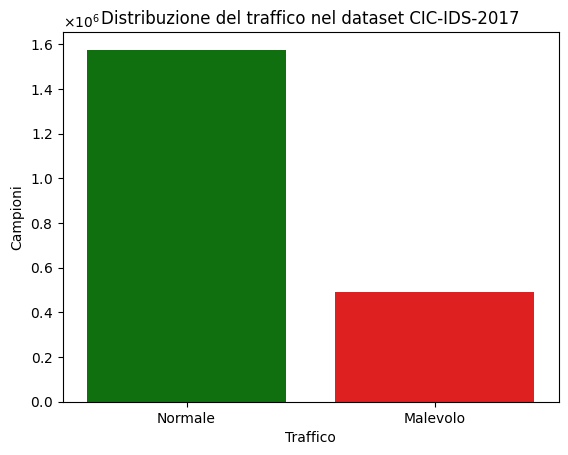

In [ ]:
## temporarily add new column to distinguish traffic type between Normal / Attack
df_plot = clean_df.copy()
trf_type = df_plot.loc[:, "Label"].map(lambda lbl: "Normale" if lbl == "BENIGN" else "Malevolo")
trf_type.name = "traffic type"
df_plot.loc[:, trf_type.name] = trf_type

### plot distrtibution of Normal traffic and Attacks in the whole dataset
plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)  # change def ScalarFormatter

sns.countplot(x="traffic type", data=df_plot, palette=["g","r"])
plt.title("Distribuzione del traffico nel dataset CIC-IDS-2017")
plt.xlabel("Traffico")
plt.ylabel("Campioni")
#salva in Drive
images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf'
plt.savefig(f"{images_dir}/distributionCICIDS2017.pdf", dpi=200, format='pdf')
plt.show()

## Feature Extraction per importanza e correlazione

In [ ]:
clean_df.columns = clean_df.columns.str.replace(' ', '')

In [ ]:
df_importance = clean_df.copy()

## feature selection phase - let's use RFC on our data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=10, n_jobs=-1) # 100 trees in forest

## feature selection phase - prepare data for RFC
lbls = df_importance.loc[:, "Label"]
data_w_o_cat_attrs = df_importance.iloc[:, :-2]

#####-------------droppo gli IP solo per fare l'analisi di importanza delle feature
data_w_o_cat_attrs = data_w_o_cat_attrs.drop('SrcIP', axis=1)
data_w_o_cat_attrs = data_w_o_cat_attrs.drop('DstIP', axis=1)

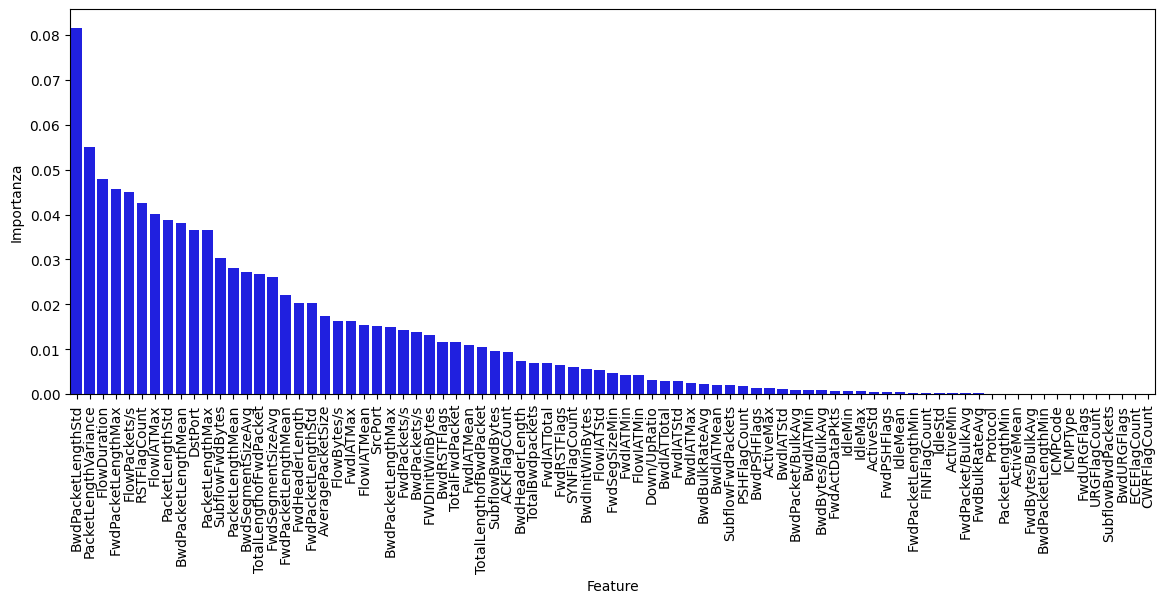

In [ ]:
# fit random forest classifier on the dataset
rfc.fit(data_w_o_cat_attrs, lbls)
RandomForestClassifier(n_jobs=-1, random_state=10)
## plotting features' importance in the whole dataset graph
# extract important features
score = np.round(rfc.feature_importances_,5)
importances = pd.DataFrame({'Feature':data_w_o_cat_attrs.columns,'Importanza':score})
importances = importances.sort_values('Importanza',ascending=False).set_index('Feature')

# plot importances
sns.barplot(x=importances.index, y="Importanza", data=importances, color="b")
plt.xticks(rotation="vertical")
plt.gcf().set_size_inches(14,5)
plt.savefig(f"{images_dir}/importanzaFeatureCICIDS2017.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.2)
plt.show()

In [ ]:
## Let's leave only the most important features
threshold = 0.0001 # importance threshold - abbassato per non togliere troppe feature che verranno controllate poi con la correlazione

bl_thresh = importances.loc[importances["Importanza"] < threshold]
print("there are {} features to delete, as they are below chosen threshold".format(bl_thresh.shape[0]))
print("these features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))

## removing these not important features
df_importance.drop(columns=feats_to_del, inplace=True) #10 feature tolte per poca importanza

there are 10 features to delete, as they are below chosen threshold
these features are the following:
FwdBytes/BulkAvg
BwdPacketLengthMin
ICMPCode
ICMPType
FwdURGFlags
URGFlagCount
SubflowBwdPackets
BwdURGFlags
ECEFlagCount
CWRFlagCount


#### Correlazioni

In [ ]:
## feature selection phase - let's find highly correlated feature pairs
data_corr_mtrx = df_importance.corr()

<ipython-input-19-f407dd2e0f88>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr_mtrx = df_importance.corr()


In [ ]:
## plotting a correlation heatmap
plt.gcf().set_size_inches(60, 60)
hm = sns.heatmap(data_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
plt.savefig(f"{images_dir}/corrHeatmapCICIDS2017before.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
## process correlation matrix, list highly correlated feature pairs
def srt_corr(mtrx):
    corr_ustack = mtrx.unstack().abs()
    #corr_ustack
    corr_srted = corr_ustack.sort_values(ascending=False)
    return corr_srted

srt_corr(data_corr_mtrx)

SrcPort            SrcPort               1.000000e+00
BwdIATMax          BwdIATMax             1.000000e+00
FwdIATMean         FwdIATMean            1.000000e+00
FwdIATStd          FwdIATStd             1.000000e+00
FwdIATMax          FwdIATMax             1.000000e+00
                                             ...     
FwdIATMean         FwdPacketLengthStd    9.219633e-05
FWDInitWinBytes    SrcPort               7.514903e-05
SrcPort            FWDInitWinBytes       7.514903e-05
SubflowFwdPackets  FwdIATTotal           9.078146e-07
FwdIATTotal        SubflowFwdPackets     9.078146e-07
Length: 5476, dtype: float64

In [ ]:
from collections import OrderedDict
thres_corr = 0.95
epoch=0
highly_corr = {"dummy": "dummy"}
feats_deled = []

all_data_corr_mtrx2 = data_corr_mtrx.copy()  # for easy
def add_to_dct(l, ft, ft2):
    try:
        l[ft].append(ft2)
    except KeyError:
        l[ft] = [ft2]

get_imp = lambda feat: importances.loc[feat][0]
srt_key = lambda elem: get_imp(elem[0])  # gets imp of first elem

def what_to_del(dct_srt):
    to_del = []  #least imp feature
    for k, val in dct_srt.items():
        ## get all indexes lower than current k
        feats_lw_imp = importances[importances.index.slice_indexer(k)].index
        if set(val) - set(feats_lw_imp):  # feat k creates a corr pair w/ feature of higher importance --- delete feat k
            if k not in to_del: to_del.append(k)
        else:  # feat k creates a corr pair w/ features of lower importnace --- delete one w/ lowest imp
            for ft in feats_lw_imp[::-1]:  # searching from least important
                if ft in val and ft not in to_del:
                    to_del.append(ft)
                    break  ## deleting first founud feat of lowest possible importance
    return to_del


while highly_corr:
    count = 0
    highly_corr.clear()
    for feats, val in srt_corr(all_data_corr_mtrx2).items():
        if val > thres_corr and feats[0] != feats[1]:
            count += 1
            add_to_dct(highly_corr, feats[0], feats[1])
    if not highly_corr: break  # no more highly corr pairs
    highly_corr_srt = OrderedDict(sorted(highly_corr.items(), key=srt_key))  # sorted based on imp

    to_del = what_to_del(highly_corr_srt)
    feats_deled += to_del
    epoch +=1 # first epoch will be 1 not 0!
    print("there are {} higly correlated pairs in {} iteration".format(count, epoch))
    all_data_corr_mtrx2.drop(to_del, axis=1, inplace=True)
    all_data_corr_mtrx2.drop(to_del, axis=0, inplace=True)  # need to remove the feat from both cols and index

print("deleting: {} feature".format(len(feats_deled)))
print("finally deleted:\n"+ "\n".join(feats_deled))

there are 106 higly correlated pairs in 1 iteration
deleting: 26 feature
finally deleted:
IdleMean
IdleMax
IdleMin
BwdBytes/BulkAvg
BwdIATMin
BwdPSHFlags
BwdIATMax
BwdIATTotal
FwdIATMin
FwdIATTotal
TotalBwdpackets
ACKFlagCount
SubflowBwdBytes
TotalLengthofBwdPacket
FwdPackets/s
BwdPacketLengthMax
FwdIATMax
AveragePacketSize
FwdPacketLengthMean
FwdSegmentSizeAvg
BwdSegmentSizeAvg
PacketLengthMean
PacketLengthMax
BwdPacketLengthMean
PacketLengthStd
PacketLengthVariance


In [ ]:
data = df_importance.copy() ## just for ease of cells executing
data.shape

(2065306, 77)

In [ ]:
data.drop(feats_deled, axis=1, inplace=True)
data_encoded = data.copy()

In [ ]:
data.shape  #26 feature tolte per la correlazione

(2065306, 51)

In [ ]:
## plotting a correlation heatmap after removing highly correlated pairs
final_corr_mtrx = data.corr()

plt.gcf().set_size_inches(60, 60)
hm2 = sns.heatmap(final_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm2.set_yticklabels(hm2.get_ymajorticklabels(), fontsize = 25)
hm2.set_xticklabels(hm2.get_xmajorticklabels(), fontsize = 25)
plt.savefig(f"{images_dir}/corrHeatmapCICIDS2017after.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
#SALVO DATASET CSV PRIMA DELL'ENCODING
data.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleaned.csv', index = False)

## Encoding

In [ ]:
#####sistemo feature categoriche = feature encoding

#cerco quelle numeriche per poi scremare e trovare le categoriche
cols = data_encoded.columns
num_cols = data_encoded._get_numeric_data().columns
print(list(set(cols) - set(num_cols)))

print("======================")
print(data_encoded.shape)

['Label', 'DstIP', 'SrcIP']
(2065306, 51)


In [ ]:
print(data_encoded['Label'].value_counts()) #7 classi finali per la classificazione del traffico

BENIGN                   1574886
DoS                       168977
Portscan                  156884
DDoS                       93578
Infiltration_Portscan      70143
Botnet                       726
WebAttacks_Heartbleed        112
Name: Label, dtype: int64


In [ ]:
#hot-encoding multi-class
## Label

cat_cols = ["Label"]
cat_cols_encoded = []
for col in cat_cols:
  cat_cols_encoded += [f"{col[0]}_{cat}" for cat in list(data_encoded[col].unique())]

cat_cols_encoded

['L_BENIGN',
 'L_DoS',
 'L_Infiltration_Portscan',
 'L_DDoS',
 'L_Portscan',
 'L_Botnet',
 'L_WebAttacks_Heartbleed']

In [ ]:
#NON FUNZIONA con onehotencoder di preprocessing lib (Dà NaN verso la fine)
#USO DUMMIES

df_finEnc = pd.get_dummies(
    data=data_encoded,
    columns=["Label"],
    prefix=["L"])

#df_finEnc['L_WebAttacks_Heartbleed'].value_counts() corretto
df_finEnc.head()

,SrcIP,SrcPort,DstIP,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalLengthofFwdPacket,FwdPacketLengthMax,FwdPacketLengthMin,...,ActiveMin,IdleStd,TotalTCPFlowTime,L_BENIGN,L_Botnet,L_DDoS,L_DoS,L_Infiltration_Portscan,L_Portscan,L_WebAttacks_Heartbleed
0,192.168.10.9,57235,192.168.10.3,53,17,270,2,82,41,41,...,0,0.0,0,1,0,0,0,0,0,0
1,192.168.10.9,50194,192.168.10.3,53,17,1214161,4,128,32,32,...,0,0.0,0,1,0,0,0,0,0,0
2,192.168.10.19,49476,192.168.10.3,53,17,1333756,2,74,37,37,...,0,0.0,0,1,0,0,0,0,0,0
3,172.16.0.1,37820,192.168.10.50,80,6,175982,9,296,296,0,...,0,0.0,175982,0,0,0,1,0,0,0
4,192.168.10.9,64579,192.168.10.3,53,17,283967,2,86,43,43,...,0,0.0,0,1,0,0,0,0,0,0


#### Binarizzo IP come encoding

In [ ]:
#CIT - https://www.mohammedalani.com/tutorials/handling-ip-addresses-in-machine-learning-datasets/
#not be able to identify the relationship between IP addresses of two hosts within the same network
#BUT
#it can be helpful in recognizing data flows, and doing statistics analysis of data originating or landing in a specific node

## ---------- BINARIZZO IP -------------- #LABEL BINARIZE
train_data = ['127.0.0.1']
df_ipEnc = df_finEnc.copy()
ip_encoder = preprocessing.LabelBinarizer()
print(df_ipEnc["SrcIP"].values[3])
df_ipEnc = ip_encoder.fit_transform(df_ipEnc["SrcIP"].values[3].split('.'))


In [ ]:
print(df_ipEnc)
print("=================")
print(df_ipEnc.tolist())

In [ ]:
#SALVO DATASET CSV PRIMA DELLA NORMALIZZAZIONE
data_encoded.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded.csv', index = False)

#### Splitting IP come encoding

In [ ]:
#Splitting IP for DstIP e SrcIP - CIT: Shao Thesis dice che è meglio splittare in 4 feature l'IP
# split the Name column into 4 columns
df_finEnc[['DstIP_1', 'DstIP_2', 'DstIP_3', 'DstIP_4']] = df_finEnc['DstIP'].str.split('.', expand=True)
df_finEnc[['SrcIP_1', 'SrcIP_2', 'SrcIP_3', 'SrcIP_4']] = df_finEnc['SrcIP'].str.split('.', expand=True)
df_finEnc["DstIP_1"] = df_finEnc["DstIP_1"].apply(int)
df_finEnc["DstIP_2"] = df_finEnc["DstIP_2"].apply(int)
df_finEnc["DstIP_3"] = df_finEnc["DstIP_3"].apply(int)
df_finEnc["DstIP_4"] = df_finEnc["DstIP_4"].apply(int)
df_finEnc["SrcIP_1"] = df_finEnc["SrcIP_1"].apply(int)
df_finEnc["SrcIP_2"] = df_finEnc["SrcIP_2"].apply(int)
df_finEnc["SrcIP_3"] = df_finEnc["SrcIP_3"].apply(int)
df_finEnc["SrcIP_4"] = df_finEnc["SrcIP_4"].apply(int)

#elimino colonne SrcIP, DstIP non più utili
df_finEnc = df_finEnc.drop('SrcIP', axis=1)
df_finEnc = df_finEnc.drop('DstIP', axis=1)

df_finEnc

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalLengthofFwdPacket,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthStd,...,L_Portscan,L_WebAttacks_Heartbleed,DstIP_1,DstIP_2,DstIP_3,DstIP_4,SrcIP_1,SrcIP_2,SrcIP_3,SrcIP_4
0,57235,53,17,270,2,82,41,41,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
1,50194,53,17,1214161,4,128,32,32,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
2,49476,53,17,1333756,2,74,37,37,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,19
3,37820,80,6,175982,9,296,296,0,98.666667,1547.981999,...,0,0,192,168,10,50,172,16,0,1
4,64579,53,17,283967,2,86,43,43,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065306,60920,53,17,116473,1,49,49,49,0.000000,0.000000,...,0,0,192,168,10,1,192,168,10,3
2065307,52752,80,6,3559942,7,20,20,0,7.559289,4129.722297,...,0,0,192,168,10,50,172,16,0,1
2065308,61611,443,6,2247446,21,910,341,0,88.258333,679.746241,...,0,0,172,217,10,227,192,168,10,8
2065309,59631,53,17,60745,2,68,34,34,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,51


In [ ]:
#SALVO DATASET CSV PRIMA DELLA NORMALIZZAZIONE
df_finEnc.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded.csv', index = False)

##Feature Normalization

In [ ]:
###Feature normalization
norm_data = df_finEnc.copy()
print(norm_data.shape) #63 feature totali
print("=================")
norm_data = norm_data.drop(columns=['L_BENIGN', 'L_DoS', 'L_Infiltration_Portscan', 'L_DDoS', 'L_Portscan', 'L_Botnet', 'L_WebAttacks_Heartbleed', 'Protocol', 'DstIP_1', 'DstIP_2', 'DstIP_3', 'DstIP_4', 'SrcIP_1', 'SrcIP_2', 'SrcIP_3', 'SrcIP_4', 'SrcPort', 'DstPort'], axis=1)
print(norm_data.shape) #45 feature totali da normalizzare

(2065306, 63)
(2065306, 45)


In [ ]:
norm_data.info()

In [ ]:
#MIN-MAX SCALING NORMALIZATION - eseguito da FEDANIDS e Li et al. (2023)

x = norm_data.values
normMinMax = preprocessing.MinMaxScaler(feature_range=(0,1))
df_minMaxScal = normMinMax.fit_transform(x)
data_ready = pd.DataFrame(df_minMaxScal, columns=norm_data.columns)

data_ready

,FlowDuration,TotalFwdPacket,TotalLengthofFwdPacket,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,...,FWDInitWinBytes,BwdInitWinBytes,FwdActDataPkts,FwdSegSizeMin,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleStd,TotalTCPFlowTime
0,0.000002,0.000009,0.000006,0.001652,0.027853,0.000000,0.000000,3.425560e-03,4.938263e-03,0.000001,...,0.000000,0.000000,0.000110,0.181818,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.010118,0.000018,0.000010,0.001289,0.021739,0.000000,0.000000,7.292077e-07,1.638895e-06,0.003519,...,0.000000,0.000000,0.000329,0.181818,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.011115,0.000009,0.000006,0.001491,0.025136,0.000000,0.000000,7.230909e-07,9.913497e-07,0.006443,...,0.000000,0.000000,0.000110,0.181818,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.001467,0.000041,0.000023,0.011926,0.000000,0.013864,0.230501,2.670728e-04,3.219193e-05,0.000159,...,0.445563,0.003586,0.000110,0.454545,0.0,0.0,0.0,0.0,0.0,0.000006
4,0.002366,0.000009,0.000007,0.001732,0.029212,0.000000,0.000000,2.394088e-06,4.687048e-06,0.001372,...,0.000000,0.000000,0.000110,0.181818,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065301,0.000971,0.000005,0.000004,0.001974,0.033288,0.000000,0.000000,3.868647e-06,5.715454e-06,0.001688,...,0.000000,0.000000,0.000000,0.181818,0.0,0.0,0.0,0.0,0.0,0.000000
2065302,0.029666,0.000032,0.000002,0.000806,0.000000,0.001062,0.614932,1.289602e-05,1.021646e-06,0.005159,...,0.125002,0.003494,0.000110,0.454545,0.0,0.0,0.0,0.0,0.0,0.000118
2065303,0.018729,0.000096,0.000071,0.013739,0.000000,0.012402,0.101217,3.513518e-05,6.517593e-06,0.000757,...,0.125002,0.005493,0.000767,0.454545,0.0,0.0,0.0,0.0,0.0,0.000074
2065304,0.000506,0.000009,0.000005,0.001370,0.023098,0.000000,0.000000,1.340405e-05,2.194135e-05,0.000293,...,0.000000,0.000000,0.000110,0.181818,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
#Unisco le colonne omesse dalla normalizzazione

#SPLITTING
* Creazione dataset piccolo (meno feature) per primi esperimenti GAN
* Creazione dataset ufficiale con #feature finali per esperimenti finali
* Divisione del dataset: test set, validation set, test set